# <font color='violet'>Preprocessing/Encoding: Explore Options</font>

This is the final preprocessing notebook before modeling. 
- Here, I'll try out models' performances given various variable encoding strategies. 
- I might want to balance the data, to see if that would actually improve model performance.
- I might also need to explore the possibility of feature reduction; I created multiple features in the previous notebook but am not yet sure if they'll be valuable in making predictions. 

I can begin to explore various models in the process of all this. After this, I'll create pipelines to make final decisions about a classifier to use. 

Notebook on which this one builds: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing2_feature_engineering.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, svm

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import random
import warnings

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/features_engineered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174119 entries, 0 to 2174118
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   order_id                      int64  
 1   user_id                       int64  
 2   order_by_user_sequence        int64  
 3   order_dow                     int64  
 4   order_hour_of_day             int64  
 5   days_since_prior_order        float64
 6   add_to_cart_sequence          int64  
 7   reordered                     int64  
 8   product_name                  object 
 9   aisle_name                    object 
 10  dept_name                     object 
 11  prior_purchases               int64  
 12  purchased_percent_prior       float64
 13  apple                         int64  
 14  bar                           int64  
 15  cream                         int64  
 16  free                          int64  
 17  fresh                         int64  
 18  green                 

In [3]:
# order_id is redundant as a combination of user and order_by_user_sequence. Delete it. 
df = df.drop(columns='order_id')
df.columns

Index(['user_id', 'order_by_user_sequence', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_sequence', 'reordered',
       'product_name', 'aisle_name', 'dept_name', 'prior_purchases',
       'purchased_percent_prior', 'apple', 'bar', 'cream', 'free', 'fresh',
       'green', 'mix', 'natural', 'organic', 'original', 'sweet', 'white',
       'purchased_early_past', 'percent_past_purchased_early'],
      dtype='object')

 <font color='violet'>Understand Naive Baseline Evaluation Metrics</font>

In [4]:
df['reordered'].mean()

0.09045641015970148

I can judge effect of my work by comparing model scores with scores of what would happen if I just guess that a random 9% of items get reordered (since 0.090 is the average of the whole 'reordered' column in this dataset). 

In [5]:
# Make an array with 196663 1s randomly dispersed aming the rest 0s. Then use that fake array
# as predictions to see what scores I'd get without using any of the work I've done/ will do. 
ones = [1] * 196663
zeroes = [0] * 1977456
array = np.concatenate([ones, zeroes])
len(array)

2174119

In [6]:
array[0:6]

array([1, 1, 1, 1, 1, 1])

In [7]:
random.shuffle(array)
array[0:6]

array([0, 0, 0, 0, 0, 0])

In [8]:
y = df['reordered']

naive RF f1 score:  0.09079999796606378
naive baseline RF kappa score:  0.00037775848260623857
naive baseline RF roc_auc score:  0.5001888792413032
naive baseline RF log_loss score:  5.681208745682688
AxesSubplot(0.125,0.11;0.62x0.77)


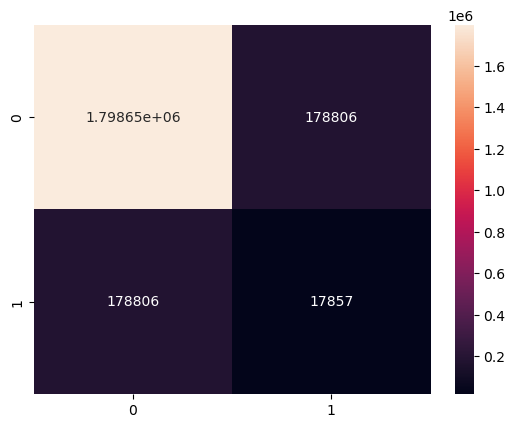

In [12]:
print('naive RF f1 score: ', metrics.f1_score(y, array))
print('naive baseline RF kappa score: ', metrics.cohen_kappa_score(y, array))
print('naive baseline RF roc_auc score: ', metrics.roc_auc_score(y, array))
print('naive baseline RF log_loss score: ', metrics.log_loss(y, array))
cm = metrics.confusion_matrix(y, array)
print(sns.heatmap(cm, annot=True, fmt='g'))

I'll be looking to get a log loss significantly lower than 5 moving forward.
- Note on log loss score: it is widely known that the log loss for a balanced binary problem is -log(1/2) or 0.69, but with unbalanced classes, the naive log loss increases, as explained here: https://stats.stackexchange.com/questions/276067/whats-considered-a-good-log-loss

My understanding is that categorical features should be encoded prior to any standardization of ordinal features. Start here. 

I'd like to try multiple encoders for categorical data. A summary of my current knowledge of encoders that could make sense for this data:
- One-Hot could work for the dept_name column because there are only 19 categories, much fewer than all the other categorical columns. It wouldn't work well for the others. 
- Hashing works with high-cardinality variables but isn't reversible and can lead to some (usuall minimal, as far as I've read) info loss. It's not clear to me whether it involves any leakage across rows. 
- My understanding of binary encoding is that it's the best of both worlds from one-hot and hashing: fewer resultant categories than one-hot but interpretable and no info loss, unlike hashing. 
- My understanding is that Bayesian encoders generally cause contamination, so make sure to split into training and test sets prior to encoding. I read that LeaveOneOut is a Bayesian encoder that avoids leakage by not using the dependent variable. I also read that it is especially good for classification tasks, so it's a good one to consider here.
- I know very little about WeightofEvidence but it's another Bayesian encoders recommended by Springboard and I can try it out along with Target encoder, which seems to be the most popular Bayesian encoder. 

I'd like any encoder(s) I use to be included in an eventual modeling pipeline, but first I want to explore and try them out individually to see what they actually do to the data in the categorical columns. 

 <font color='violet'>Binary Encoder</font>

Start by just predicting the reordered column. Perhaps try predicting the add_to_cart_sequence column later. Create independent & dependent variables; encode independent categories.

In [10]:
X = df.drop(columns=['reordered', 'add_to_cart_sequence'])
y = df['reordered']

categorical_columns = ['user_id', 'product_name', 'aisle_name', 'dept_name']
ce_bin = ce.BinaryEncoder(cols=categorical_columns)
Xbin = ce_bin.fit_transform(X,y)

In [11]:
Xbin.head()

,user_id_0,user_id_1,user_id_2,user_id_3,user_id_4,user_id_5,user_id_6,user_id_7,user_id_8,user_id_9,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0


In [12]:
Xbin.columns

Index(['user_id_0', 'user_id_1', 'user_id_2', 'user_id_3', 'user_id_4',
       'user_id_5', 'user_id_6', 'user_id_7', 'user_id_8', 'user_id_9',
       'user_id_10', 'user_id_11', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_name_0',
       'product_name_1', 'product_name_2', 'product_name_3', 'product_name_4',
       'product_name_5', 'product_name_6', 'product_name_7', 'product_name_8',
       'product_name_9', 'product_name_10', 'product_name_11',
       'product_name_12', 'product_name_13', 'product_name_14', 'aisle_name_0',
       'aisle_name_1', 'aisle_name_2', 'aisle_name_3', 'aisle_name_4',
       'aisle_name_5', 'aisle_name_6', 'aisle_name_7', 'dept_name_0',
       'dept_name_1', 'dept_name_2', 'dept_name_3', 'dept_name_4',
       'prior_purchases', 'purchased_percent_prior', 'apple', 'bar', 'cream',
       'free', 'fresh', 'green', 'mix', 'natural', 'organic', 'original',
       'sweet', 'white', 'purchased_early_past',


binary bagging f1 score:  0.23791675917098715
binary bagging kappa score:  0.2052455706172115
binary bagging roc_auc score:  0.5699450975998187
binary bagging log_loss score:  3.090165013302997
AxesSubplot(0.125,0.11;0.62x0.77)


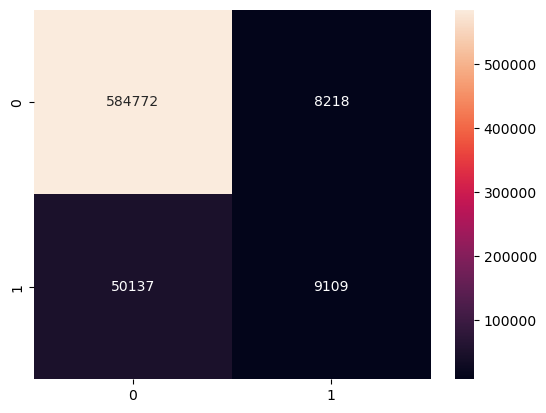

In [13]:
# Test out encoder performance in Bagging and RandomForest models. 
# These were better than others when trying them out with a practice user.
# First need to standardize. Don't bother yet with tuning model hyperparameters.

Xbin_train, Xbin_test, ybin_train, ybin_test = train_test_split(Xbin, y, test_size=0.3)

scaler = StandardScaler()
Xbin_train_scaled = scaler.fit_transform(Xbin_train)
Xbin_test_scaled = scaler.transform(Xbin_test)

bgg_clf = BaggingClassifier()
bgg_clf = bgg_clf.fit(Xbin_train_scaled, ybin_train)
ybin_pred = bgg_clf.predict(Xbin_test_scaled)
print('binary bagging f1 score: ', metrics.f1_score(ybin_test, ybin_pred))
print('binary bagging kappa score: ', metrics.cohen_kappa_score(ybin_test, ybin_pred))
print('binary bagging roc_auc score: ', metrics.roc_auc_score(ybin_test, ybin_pred))
print('binary bagging log_loss score: ', metrics.log_loss(ybin_test, ybin_pred))
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

binary RF f1 score:  0.2635020199872422
binary RF kappa score:  0.233905126835658
binary RF roc_auc score:  0.5785347882607469
binary RF log_loss score:  2.9347411914630683
AxesSubplot(0.125,0.11;0.62x0.77)


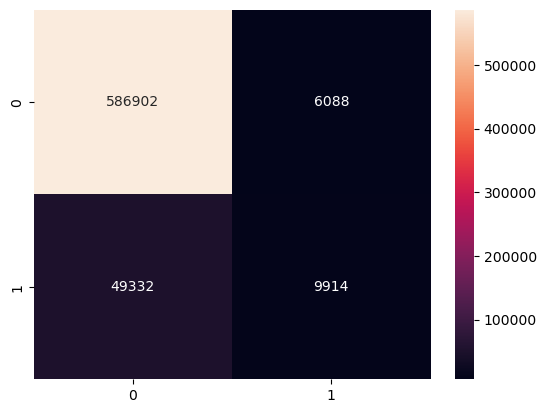

In [14]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xbin_train_scaled, ybin_train)
ybin_pred = rf_clf.predict(Xbin_test_scaled)
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print('binary RF f1 score: ', metrics.f1_score(ybin_test, ybin_pred))
print('binary RF kappa score: ', metrics.cohen_kappa_score(ybin_test, ybin_pred))
print('binary RF roc_auc score: ', metrics.roc_auc_score(ybin_test, ybin_pred))
print('binary RF log_loss score: ', metrics.log_loss(ybin_test, ybin_pred))
cm = metrics.confusion_matrix(ybin_test, ybin_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Leave One Out Encoder</font>

In [15]:
# Try a Bayesian encoder. Start with LeaveOneOut. Even though it has less contaminiation
# than other Bayesian encoders, it's best to split data first. 

Xloo_train, Xloo_test, yloo_train, yloo_test = train_test_split(X, y, test_size=0.3)

ce_loo = ce.leave_one_out.LeaveOneOutEncoder(cols=categorical_columns, random_state=43)
ce_loo.fit(Xloo_train, yloo_train)
Xloo_train = ce_loo.transform(Xloo_train)
Xloo_test = ce_loo.transform(Xloo_test)

Xloo_train.head()

,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
1241637,0.075495,17,1,18,6.0,0.000000,0.028887,0.032212,1,0.058824,...,0,0,0,0,0,0,0,0,0,0.000000
1220663,0.065457,24,3,17,2.0,0.000000,0.067699,0.054265,1,0.041667,...,0,0,0,0,0,0,0,0,0,0.000000
1203860,0.211793,23,0,8,10.0,0.000000,0.072913,0.069616,1,0.043478,...,0,0,0,0,0,0,0,0,1,0.043478
2101772,0.094453,29,5,11,15.0,0.129032,0.055985,0.099753,2,0.068966,...,0,0,0,0,0,0,0,1,1,0.034483
1899372,0.114676,39,1,16,3.0,0.080645,0.064176,0.058679,2,0.051282,...,0,0,0,0,0,0,0,0,1,0.025641


In [16]:
print('prod min', Xloo_train['product_name'].min())
print('prod max', Xloo_train['product_name'].max())

prod min 0.0
prod max 1.0


LeaveOneOut bagging f1 score:  0.26707732371794873
LeaveOneOut bagging kappa score:  0.2307775958994306
LeaveOneOut bagging roc_auc score:  0.5817464346841479
LeaveOneOut bagging log_loss score:  3.099963945064664
AxesSubplot(0.125,0.11;0.62x0.77)


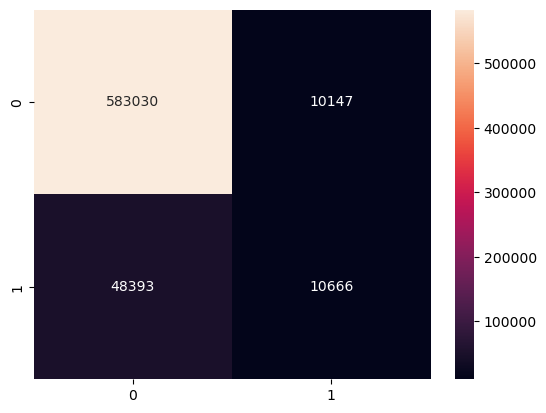

In [17]:
# Now try this encoded data in models after standardization

scaler = StandardScaler()
Xloo_train_scaled = scaler.fit_transform(Xloo_train)
Xloo_test_scaled = scaler.transform(Xloo_test)

bgg_clf = BaggingClassifier()
bgg_clf = bgg_clf.fit(Xloo_train_scaled, yloo_train)
yloo_pred = bgg_clf.predict(Xloo_test_scaled)
print('LeaveOneOut bagging f1 score: ', metrics.f1_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging kappa score: ', metrics.cohen_kappa_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging roc_auc score: ', metrics.roc_auc_score(yloo_test, yloo_pred))
print('LeaveOneOut bagging log_loss score: ', metrics.log_loss(yloo_test, yloo_pred))
cm = metrics.confusion_matrix(yloo_test, yloo_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

LeaveOneOut RF f1 score:  0.2791943152724803
LeaveOneOut RF kappa score:  0.2480719972862283
LeaveOneOut RF roc_auc score:  0.5847370427798204
LeaveOneOut RF log_loss score:  2.9221389256073884
AxesSubplot(0.125,0.11;0.62x0.77)


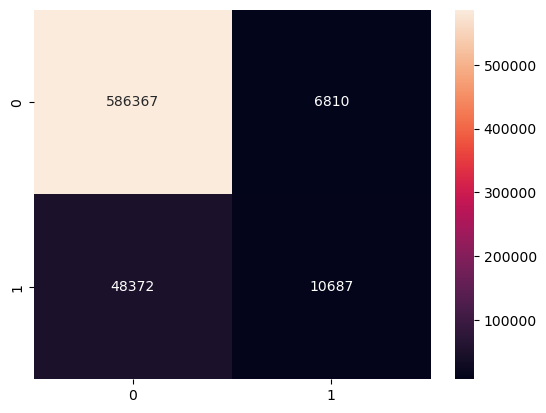

In [18]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xloo_train_scaled, yloo_train)
yloo_pred = rf_clf.predict(Xloo_test_scaled)
print('LeaveOneOut RF f1 score: ', metrics.f1_score(yloo_test, yloo_pred))
print('LeaveOneOut RF kappa score: ', metrics.cohen_kappa_score(yloo_test, yloo_pred))
print('LeaveOneOut RF roc_auc score: ', metrics.roc_auc_score(yloo_test, yloo_pred))
print('LeaveOneOut RF log_loss score: ', metrics.log_loss(yloo_test, yloo_pred))
cm = metrics.confusion_matrix(yloo_test, yloo_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Target Encoder</font>
 
Try the other Bayesian encoders. Just stick with a random forest classifier for now becaue it seems to perform better tha bagging. 

In [19]:
Xtar_train, Xtar_test, ytar_train, ytar_test = train_test_split(X, y, test_size=0.3)

ce_tar = ce.target_encoder.TargetEncoder(cols=categorical_columns)
ce_tar.fit(Xtar_train, ytar_train)
Xtar_train = ce_tar.transform(Xtar_train)
Xtar_test = ce_tar.transform(Xtar_test)

Xtar_train.head()

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
1678105,0.103448,2,1,16,30.0,0.035176,0.041614,0.032063,1,0.500000,...,0,0,0,0,1,0,0,0,0,0.000000
102068,0.078921,48,0,17,4.0,0.164700,0.087581,0.123310,10,0.208333,...,0,0,0,0,1,0,0,0,2,0.041667
462759,0.073744,54,6,8,10.0,0.106299,0.111291,0.111828,5,0.092593,...,0,0,0,0,0,0,0,0,3,0.055556
348669,0.173077,4,0,19,30.0,0.158730,0.085969,0.082957,2,0.500000,...,0,0,0,0,0,0,0,0,1,0.250000
686686,0.099096,33,0,11,7.0,0.000000,0.020396,0.032063,1,0.030303,...,0,0,0,0,1,1,0,0,1,0.030303


In [20]:
print('prod min', Xtar_train['product_name'].min())
print('prod max', Xtar_train['product_name'].max())

prod min 0.0
prod max 0.9999979438200647


Target RF f1 score:  0.27715346051175205
Target RF kappa score:  0.24580029841131557
Target RF roc_auc score:  0.5840113328317595
Target RF log_loss score:  2.9395610890285866
AxesSubplot(0.125,0.11;0.62x0.77)


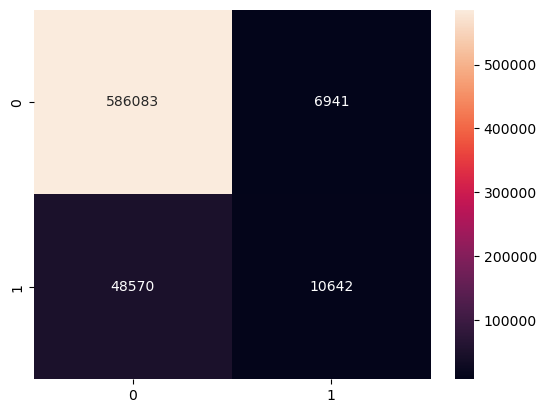

In [21]:
scaler = StandardScaler()
Xtar_train_scaled = scaler.fit_transform(Xtar_train)
Xtar_test_scaled = scaler.transform(Xtar_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xtar_train_scaled, ytar_train)
ytar_pred = rf_clf.predict(Xtar_test_scaled)
print('Target RF f1 score: ', metrics.f1_score(ytar_test, ytar_pred))
print('Target RF kappa score: ', metrics.cohen_kappa_score(ytar_test, ytar_pred))
print('Target RF roc_auc score: ', metrics.roc_auc_score(ytar_test, ytar_pred))
print('Target RF log_loss score: ', metrics.log_loss(ytar_test, ytar_pred))
cm = metrics.confusion_matrix(ytar_test, ytar_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

 <font color='violet'>Weight of Evidence Encoder</font>

TargetEncoder seems to perform comprably with LeaveOneOut. Try WeightofEvidence. 

In [22]:
Xwoe_train, Xwoe_test, ywoe_train, ywoe_test = train_test_split(X, y, test_size=0.3)

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43)
ce_woe.fit(Xwoe_train, ywoe_train)
Xwoe_train = ce_woe.transform(Xwoe_train)
Xwoe_test = ce_woe.transform(Xwoe_test)

Xwoe_train.head()

,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior,...,fresh,green,mix,natural,organic,original,sweet,white,purchased_early_past,percent_past_purchased_early
1706797,-1.191071,90,3,17,3.0,-0.242409,-0.528501,-0.136421,0,0.000000,...,0,0,0,0,1,0,0,0,0,0.00
170543,0.430866,4,2,16,7.0,-1.341022,-1.339295,-1.091708,1,0.250000,...,0,0,0,0,0,0,0,0,0,0.00
325777,0.290068,50,1,6,3.0,0.167033,-0.025178,0.239666,1,0.020000,...,0,0,0,0,1,0,0,0,1,0.02
1020713,0.584717,14,2,17,5.0,-0.986200,-1.081991,-0.959776,1,0.071429,...,0,0,0,0,0,0,0,0,0,0.00
814671,0.420747,18,6,9,6.0,0.330380,0.238380,0.239666,3,0.166667,...,0,0,0,0,1,0,0,0,0,0.00


In [23]:
# Unlike the others, this encoder seems to return a range of values. What do these look like?

print('prod min', Xwoe_train['product_name'].min())
print('prod max', Xwoe_train['product_name'].max())

prod min -3.7306180347206883
prod max 5.305368950110716


In [24]:
print('dept min', Xwoe_train['dept_name'].min())
print('dept max', Xwoe_train['dept_name'].max())

dept min -1.0971734420103874
dept max 0.37821945505842813


In [25]:
print('user min', Xwoe_train['user_id'].min())
print('user max', Xwoe_train['user_id'].max())

user min -2.167700137921481
user max 3.8137140733329997


WeightofEvidence RF f1 score:  0.2743086820916363
WeightofEvidence RF kappa score:  0.2430505185446059
WeightofEvidence RF roc_auc score:  0.5829360156503187
WeightofEvidence RF log_loss score:  2.944750599717889
AxesSubplot(0.125,0.11;0.62x0.77)


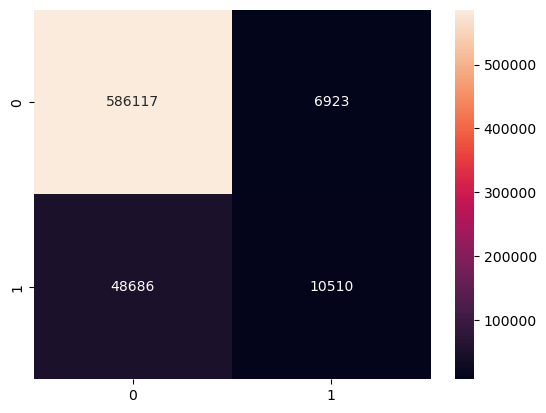

In [26]:
scaler = StandardScaler()
Xwoe_train_scaled = scaler.fit_transform(Xwoe_train)
Xwoe_test_scaled = scaler.transform(Xwoe_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xwoe_train_scaled, ywoe_train)
ywoe_pred = rf_clf.predict(Xwoe_test_scaled)
print('WeightofEvidence RF f1 score: ', metrics.f1_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF kappa score: ', metrics.cohen_kappa_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('WeightofEvidence RF log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))
cm = metrics.confusion_matrix(ywoe_test, ywoe_pred)
print(sns.heatmap(cm, annot=True, fmt='g'))

WeightOfEvidence performed comparably to other Bayesian encoders. For further exploration, I'll just use WOE and compare evaluation scores with those immediately above. 

I can prune the metrics I'm using. The F1 score is easily-explainable and also redundant with the confusion matrix. Kappa isn't super intutive and doesn't seem to vary/provide additional information relative to other metrics. ROC tells how much a model is capable of distinguishing between classes and is a bit more easily explainable than log loss. Log loss, being the log of the likelihood function (how likely it is that a model's predictions are the actual outcomes), is perhaps the most important metric for evaluation. So, in making my selections, I'll prioritize log loss, but I'll consider the area under the curve as well. In the future, I could re-introduce the F1 score and/or confusion matrix in order to better explain model performance to stakeholders. 

Next, I need to play around and see if any further adjustments to the rows and columns will help improve modeling. 

 <font color='violet'>Try resampling to inspect its effects on model performance: over-sample, under-sample, balanced SVM</font>

In [27]:
# Oversample first. Split into train-test sets so I'm only over-sampling the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Put training sets back together for purposes of oversampling
train_set = pd.concat([X_train, y_train], axis=1)
print(X_train.shape, train_set.shape)

(1521883, 24) (1521883, 25)


In [28]:
len(df[df['reordered']==1])

196663

In [29]:
# Over-sample the minority class in the training data, to quadruple its size.
over_sampled3 = train_set[train_set['reordered']==1].sample(n=589989, axis=0, replace=True, 
                                                            random_state=43)  
quadrupled_reorders = pd.concat([train_set, over_sampled3])
quadrupled_reorders.shape

(2111872, 25)

In [30]:
# Now re-split X_train and y_train, then run through encoding and modeling. 

Xo_train = quadrupled_reorders.drop(columns=['reordered'])
yo_train = quadrupled_reorders['reordered']

# Try out with WOE encoder & RandomForest
ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43)
ce_woe.fit(Xo_train, yo_train)
Xo_train = ce_woe.transform(Xo_train)
X_test = ce_woe.transform(X_test)

scaler = StandardScaler()
Xo_train_scaled = scaler.fit_transform(Xo_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xo_train_scaled, yo_train)
y_pred = rf_clf.predict(X_test_scaled)

print('quadruple oversample roc_auc: ', metrics.roc_auc_score(y_test, y_pred))
print('quadruple oversample log_loss: ', metrics.log_loss(y_test, y_pred))

quadruple oversample roc_auc:  0.6186961139540238
quadruple oversample log_loss:  3.0555404408123126


This modeling with over-sampled training data performed less well than the same encoder/classifier using the original data. 

Next, try a different method for dealing with unbalanced data. 

In [31]:
# Undersample the majority class. Cut the index in half. This will leave the dataset with about 
# a 5:1 non-reorders:reorders. Rather than the original ratio of 9:1
len(train_set)

1521883

In [32]:
index_to_drop = random.sample(train_set.index.to_list(),760942)
undersampled = train_set.drop(index_to_drop)
len(undersampled)

760941

In [33]:
# Again, re-split X_train and y_train, then run through encoding and modeling. 

Xu_train = undersampled.drop(columns=['reordered'])
yu_train = undersampled['reordered']

# Try out with WOE encoder & RandomForest
ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43)
ce_woe.fit(Xo_train, yo_train)
Xu_train = ce_woe.transform(Xu_train)
X_test = ce_woe.transform(X_test)

scaler = StandardScaler()
Xu_train_scaled = scaler.fit_transform(Xu_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xu_train_scaled, yu_train)
y_pred = rf_clf.predict(X_test_scaled)

print('undersampled roc_auc: ', metrics.roc_auc_score(y_test, y_pred))
print('undersampled log_loss: ', metrics.log_loss(y_test, y_pred))

undersampled roc_auc:  0.5792350248898528
undersampled log_loss:  3.324920182063632


In [34]:
# Undersampling is definitely a bad idea, even with the large size of the data. 
# Try using a support vector macine's class_weight parameter to balance the classes. 
# Work from the data previously encoded using WOE Encoder. 

svm_svc_clf = svm.SVC(class_weight='balanced', max_iter=1, random_state=43)
svm_svc_clf = svm_svc_clf.fit(Xwoe_train_scaled, ywoe_train)
ywoe_pred = svm_svc_clf.predict(Xwoe_test_scaled)
print('Target SVM balance roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('Target SVM balance log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Target SVM balance roc_auc score:  0.5
Target SVM balance log_loss score:  31.404813819687707


The SVM model, even with balancing, performed as absysmally as the last time I tried. 

 <font color='violet'>Try removing rows where department = missing, since this category of products may bring incoherence to the dept_name feature.</font>

In [35]:
# Get new dataset with missing rows removed
missing_dept = df[df['dept_name']=='missing'].index.to_list()
df_no_missing_dept = df.drop(missing_dept)
print(len(df), len(df_no_missing_dept))

2174119 2170652


In [36]:
# Try modeling with this dataset. 

X_no_miss = df_no_missing_dept.drop(columns=['reordered', 'add_to_cart_sequence'])
y_no_miss = df_no_missing_dept['reordered']
X_no_miss_train, X_no_miss_test, y_no_miss_train, y_no_miss_test = train_test_split(
    X_no_miss, y_no_miss, test_size=0.3)

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43)
ce_woe.fit(X_no_miss_train, y_no_miss_train)
Xwoe_train = ce_woe.transform(X_no_miss_train)
Xwoe_test = ce_woe.transform(X_no_miss_test)

scaler = StandardScaler()
X_no_miss_train_scaled = scaler.fit_transform(Xwoe_train)
X_no_miss_test_scaled = scaler.transform(Xwoe_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_no_miss_train_scaled, y_no_miss_train)
y_no_miss_pred = rf_clf.predict(X_no_miss_test_scaled)

print('WOE CF w/o missing dept roc_auc score: ', metrics.roc_auc_score(
    y_no_miss_test, y_no_miss_pred))
print('WOE CF w/o missing dept log_loss score: ', metrics.log_loss(
    y_no_miss_test, y_no_miss_pred))

WOE CF w/o missing dept roc_auc score:  0.5853671146219892
WOE CF w/o missing dept log_loss score:  2.9194335012979726


Evaluation metrics from when I used the same encoder and classifer without dropping rows that had a 'missing' department name:

- WeightofEvidence RF roc_auc score:  0.5829360156503187
- WeightofEvidence RF log_loss score:  2.944750599717889

The log loss is lower and the area under the curve is higher when dropping all rows involving orders of products from the 'missing' department. My hypothesis is that these items did in fact bring incoherence to the dept_name column by skewing patterns in inherent 'reorder-ability' for popular departments such as 'dairy & eggs.'

In a real-world situation, if we definitely wanted to be able to recommend those items currently in the 'missing' department, it would make more sense to reclassify items. As it is, if I keep the missing department's rows, they hinder the model's ability to correctly predict all other items' reorders. 

 <font color='violet'>PCA</font>
 
Finally, try dimensionality reduction to see if this improves performance at all. 

Find intrinsic dimensions of independent variables from a training set. Use the encoded, normalized training set from the df I just created with all rows except those where the department name was missing. 

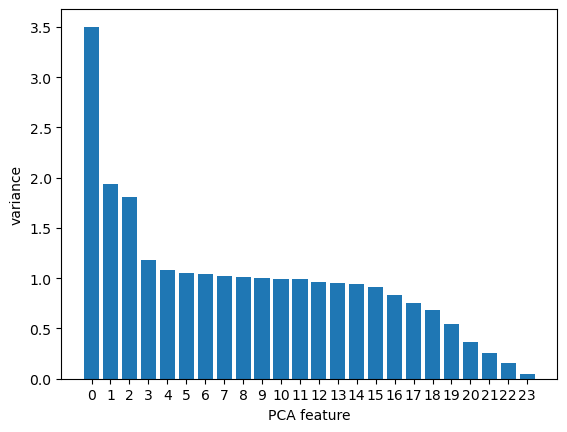

In [37]:
pca = PCA()
pca.fit(X_no_miss_train_scaled)
features = range(pca.n_components_)

#Plot variances of PCA featuers
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [38]:
pca.explained_variance_

array([3.5021547 , 1.93238525, 1.80374474, 1.17819233, 1.08042779,
       1.05057949, 1.04078505, 1.02365029, 1.00938969, 0.99987922,
       0.99679288, 0.99128187, 0.96038352, 0.95430189, 0.93966363,
       0.90881941, 0.82932179, 0.75069184, 0.68646842, 0.54147558,
       0.36148173, 0.25535217, 0.15364445, 0.04914805])

In [39]:
# Reduce dimensions of training set independent variables to 17 based on the plot. (Change in 
# variance plateaus at PCA feature 3, then drops again after feature 16; keep through plateau)

pca = PCA(n_components=17)
pca.fit(Xwoe_train_scaled)
X_reduced_train = pca.transform(X_no_miss_train_scaled)
X_reduced_test = pca.transform(X_no_miss_test_scaled)

# Continue with modeling
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_reduced_train, y_no_miss_train)
y_reduced_pred = rf_clf.predict(X_reduced_test)
print('dimensions reduced RF roc_auc score: ', metrics.roc_auc_score(ywoe_test, ywoe_pred))
print('dimensions reduced RF log_loss score: ', metrics.log_loss(ywoe_test, ywoe_pred))

dimensions reduced RF roc_auc score:  0.5
dimensions reduced RF log_loss score:  31.404813819687707


PCA wasn't helpful. I did try changing the value of n_components a couple times (i.e. 3,4), and the performance was similar to when n_components = 17. It seems that maintaining all features helps the model perform better. 

 <font color='violet'>Encoder Optimization</font>
 
All three Bayesian encoders performed better than the binary encoder and comparably well to each other. I'll need to include various parameter values and do hyperparameter tuning for each encoder in order to settle on a strategy for encoding data before moving into modeling.

First, I've been evaluating these encoders via results of a random forest classifier. I'll keep doing that, but I've heard that RF doesn't requre standardized data. But does standardization help/hurt? I'll check that out, and then get into more in-depth hyperparameter tuning for encoders. 

In [40]:
# Use the same code as before, just delete the standard scaler step.

ce_woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43)
ce_woe.fit(X_no_miss_train, y_no_miss_train)
Xwoe_train = ce_woe.transform(X_no_miss_train)
Xwoe_test = ce_woe.transform(X_no_miss_test)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(Xwoe_train, y_no_miss_train)
y_no_miss_pred = rf_clf.predict(Xwoe_test)

print('WOE CF w/o missing dept roc_auc score: ', metrics.roc_auc_score(
    y_no_miss_test, y_no_miss_pred))
print('WOE CF w/o missing dept log_loss score: ', metrics.log_loss(
    y_no_miss_test, y_no_miss_pred))

WOE CF w/o missing dept roc_auc score:  0.5849943240917043
WOE CF w/o missing dept log_loss score:  2.9168875046611795


The RF classifier does actually perform very, very slightly better without standardization, so skip that step when testing various encoder hyperparameters in an RF classifier. 

My understanding is that sklearn tools like GridSearchCV or Random Search only support the tuning of hyperparameters for 'estimators' or classifiers, so I'll need my own for loop to optimize these encoders.

<font color='violet'>Hyperparameter Tuning</font>

Encoder hyperparameter tuning was actually taking too long with the full dataset. Using just a portion of this data to select an encoder might not result in as perfect a selection, but it'll be the best choice I can make. 

In [41]:
len(df['user_id'].unique())

2060

In [42]:
all_users = set(df['user_id'].unique())
users_for_tuning = random.sample(list(all_users), 206)
df_for_tuning = df.loc[df['user_id'].isin(users_for_tuning), :].copy()
df_for_tuning.shape

(187070, 26)

In [43]:
categorical_columns=['user_id', 'product_name', 'aisle_name', 'dept_name']

X = df_for_tuning.drop(columns=['reordered', 'add_to_cart_sequence'])
y = df_for_tuning['reordered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

results=[]

# Establish possible hyperparameters
p_drop_invariant = [True, False]
p_min_sample_leaf = [1,2,3]
p_smoothing = [0.5,1,2,3]
p_sigma = [0.05,0.2,0.4,0.6]
p_randomized = [True, False]
p_regularization = [0.5,1,2,3]

In [44]:
# Tune hyperparameters for WeightOfEvidence Encoder
for di in p_drop_invariant:
    for rand in p_randomized:
        for sig in p_sigma:
            for reg in p_regularization:
                woe = ce.woe.WOEEncoder(cols=categorical_columns, random_state=43, 
                                        drop_invariant=di, randomized=rand, sigma=sig, 
                                        regularization=reg)
                woe.fit(X_train, y_train)
                X_woe_train = woe.transform(X_train)
                X_woe_test = woe.transform(X_test)
                
                rf = RandomForestClassifier()
                rf_clf = rf.fit(X_woe_train, y_train)
                y_pred = rf.predict(X_woe_test)
                
                results.append({'encoder':'woe', 'drop_invariant':di, 'ranomized':rand,
                                'sigma':sig, 'regularization':reg, 
                                'roc_auc':metrics.roc_auc_score(y_test, y_pred),
                                'log_loss':metrics.log_loss(y_test, y_pred)})

In [45]:
# Tune hyperparameters for the LeaveOneOut encoder
for di in p_drop_invariant:
    for sig in p_sigma:
        loo = ce.leave_one_out.LeaveOneOutEncoder(cols=categorical_columns, random_state=43,
                                                    drop_invariant=di, sigma=sig)
        loo.fit(X_train, y_train)
        X_loo_train = loo.transform(X_train)
        X_loo_test = loo.transform(X_test)
        
        rf = RandomForestClassifier()
        rf_clf = rf.fit(X_loo_train, y_train)
        y_pred = rf.predict(X_loo_test)
        
        results.append({'encoder':'loo', 'drop_invariant':di, 'sigma':sig, 
                        'roc_auc':metrics.roc_auc_score(y_test, y_pred),
                        'log_loss':metrics.log_loss(y_test, y_pred)})

In [46]:
# It keeps giving me a warning that default values are changing soon; suppress the warning.
warnings.simplefilter(action='ignore', category=FutureWarning)

# Tune hyperparameters for Target Encoder
for di in p_drop_invariant:
    for msl in p_min_sample_leaf:
        for sm in p_smoothing:
            target = ce.target_encoder.TargetEncoder(cols=categorical_columns, drop_invariant=di,
                                                     min_samples_leaf=msl, smoothing=sm)
            target.fit(X_train, y_train)
            X_tar_train = target.transform(X_train)
            X_tar_test = target.transform(X_test)
            
            rf = RandomForestClassifier()
            rf_clf = rf.fit(X_tar_train, y_train)
            y_pred = rf.predict(X_tar_test)
            
            results.append({'encoder':'target', 'drop_invariant':di, 'min_sample_leaf':msl,
                           'smoothing':sm, 'roc_auc':metrics.roc_auc_score(y_test, y_pred),
                           'log_loss':metrics.log_loss(y_test, y_pred)})

In [47]:
# Sort results
results = pd.DataFrame(results)
results.sort_values('log_loss').head(10)

,encoder,drop_invariant,ranomized,sigma,regularization,roc_auc,log_loss,min_sample_leaf,smoothing
81,target,True,NaN,NaN,NaN,0.610497,3.074105,3.0,1.0
93,target,False,NaN,NaN,NaN,0.608169,3.077182,3.0,1.0
79,target,True,NaN,NaN,NaN,0.609239,3.081490,2.0,3.0
86,target,False,NaN,NaN,NaN,0.609261,3.085183,1.0,2.0
53,woe,False,False,0.2,1.0,0.609424,3.085183,NaN,NaN
41,woe,False,True,0.4,1.0,0.608418,3.087029,NaN,NaN
38,woe,False,True,0.2,2.0,0.608603,3.090722,NaN,NaN
91,target,False,NaN,NaN,NaN,0.607902,3.093799,2.0,3.0
90,target,False,NaN,NaN,NaN,0.608960,3.093799,2.0,2.0
92,target,False,NaN,NaN,NaN,0.607892,3.094414,3.0,0.5


Most of the best-performing combinations were with the target encoder. I'll try running it again with another chunk of the users, to see if the best hyperparameter combinations look similar. The 0.5 smoothing value didn't do as well; replace it with some higher values. 

In [48]:
leftover_users = set(df['user_id'].unique()) - set(users_for_tuning)
len(leftover_users)

1854

In [49]:
second_chunk_users = random.sample(list(leftover_users), 206)
second_tuning_df = df.loc[df['user_id'].isin(second_chunk_users), :].copy()
second_tuning_df.shape

(212053, 26)

In [51]:
X = second_tuning_df.drop(columns=['reordered', 'add_to_cart_sequence'])
y = second_tuning_df['reordered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

second_results=[]

# Establish possible hyperparameters
p_drop_invariant = [True, False]
p_min_sample_leaf = [1,2,3,4,5]
p_smoothing = [1,2,3,4,5]

warnings.simplefilter(action='ignore', category=FutureWarning)

for di in p_drop_invariant:
    for msl in p_min_sample_leaf:
        for sm in p_smoothing:
            target = ce.target_encoder.TargetEncoder(cols=categorical_columns, drop_invariant=di,
                                                     min_samples_leaf=msl, smoothing=sm)
            target.fit(X_train, y_train)
            X_tar_train = target.transform(X_train)
            X_tar_test = target.transform(X_test)
            
            rf = RandomForestClassifier()
            rf_clf = rf.fit(X_tar_train, y_train)
            y_pred = rf.predict(X_tar_test)
            
            second_results.append({'encoder':'target', 'drop_invariant':di, 'min_sample_leaf':msl,
                           'smoothing':sm, 'roc_auc':metrics.roc_auc_score(y_test, y_pred),
                           'log_loss':metrics.log_loss(y_test, y_pred)})

In [52]:
second_results = pd.DataFrame(second_results)
second_results.sort_values('log_loss').head(10)

,encoder,drop_invariant,min_sample_leaf,smoothing,roc_auc,log_loss
9,target,True,2,5,0.610346,3.013794
44,target,False,4,5,0.609356,3.015422
37,target,False,3,3,0.608152,3.016508
4,target,True,1,5,0.608579,3.017594
28,target,False,1,4,0.609395,3.017594
48,target,False,5,4,0.607423,3.020309
45,target,False,5,1,0.606524,3.020851
21,target,True,5,2,0.607249,3.021937
3,target,True,1,4,0.609623,3.021938
5,target,True,2,1,0.609810,3.024110


In both iterations of the loop, setting drop_invariant to False was clearly best. It seems that all the best min_sample_leaf values are odd, and smoothing values are best if under 5. Try one more time, narrowing parameters down to these values.  

In [53]:
leftover_users_third = set(leftover_users) - set(second_chunk_users)
len(leftover_users_third)

1648

In [54]:
third_chunk_users = random.sample(list(leftover_users_third), 206)
third_tuning_df = df.loc[df['user_id'].isin(third_chunk_users), :].copy()
third_tuning_df.shape

(198452, 26)

In [55]:
X = third_tuning_df.drop(columns=['reordered', 'add_to_cart_sequence'])
y = third_tuning_df['reordered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

third_results=[]

# Establish possible hyperparameters
p_min_sample_leaf = [1,3,5]
p_smoothing = [1,2,3,4]

warnings.simplefilter(action='ignore', category=FutureWarning)

for msl in p_min_sample_leaf:
    for sm in p_smoothing:
        target = ce.target_encoder.TargetEncoder(cols=categorical_columns, drop_invariant=False,
                                                 min_samples_leaf=msl, smoothing=sm)
        target.fit(X_train, y_train)
        X_tar_train = target.transform(X_train)
        X_tar_test = target.transform(X_test)
        
        rf = RandomForestClassifier()
        rf_clf = rf.fit(X_tar_train, y_train)
        y_pred = rf.predict(X_tar_test)
        
        third_results.append({'encoder':'target', 'min_sample_leaf':msl, 'smoothing':sm, 
                              'roc_auc':metrics.roc_auc_score(y_test, y_pred),
                              'log_loss':metrics.log_loss(y_test, y_pred)})

In [56]:
third_results = pd.DataFrame(third_results)
third_results.sort_values('log_loss').head(10)

,encoder,min_sample_leaf,smoothing,roc_auc,log_loss
11,target,5,4,0.603555,2.980152
3,target,1,4,0.604475,2.983053
9,target,5,2,0.602493,2.991175
7,target,3,4,0.604175,2.991755
1,target,1,2,0.605867,2.991756
10,target,5,3,0.602186,2.995236
4,target,3,1,0.602589,2.995236
5,target,3,2,0.603134,2.996396
2,target,1,3,0.604324,2.997557
6,target,3,3,0.601359,3.001617


In [ ]:
Audio(sound_file, autoplay=True)

 <font color='violet'>Finalize Encoding & Next Steps</font>

- There's not one clear winning set of hyperparameters for the Target Encoder, but the default values of 1 for min_sample_leaf and smoothing appear at least as often as any other values in the top three combinations of each trial. I'll stick with this when encoding data from the full dataset. 
- Don't finalize the encoding now because it would require saving multiple datasets (separate training and test sets) and uploading them all into the next notebook. Save the dataset with the 'missing' department removed, and in the modeling notebook, simply do encoding as a first step prior to model tuning. 
- Modeling notebook: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/8-kl-modeling.ipynb

In [58]:
for_modeling = df_no_missing_dept
datapath = '../data/processed'
save_file(for_modeling, 'for_modeling.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/processed/for_modeling.csv"
